# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 43391,
  "iopub_port": 55569,
  "stdin_port": 46309,
  "control_port": 41855,
  "hb_port": 37523,
  "ip": "127.0.0.1",
  "key": "e42ddf8d-d8d5ea8705ec9ae3b4759dc7",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-0bdca302-a060-4344-be83-afe795e4500d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test_zjets_xsection/'
selections = [
              'ee',   'emu',  'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets)

In [3]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    sdata = fit_data.get_selection_data(selection)
    for category, bdata in sdata.items():
        
        templates = bdata['templates']
        # signal component
        toy_data[selection][category] = np.zeros(bdata['bins'].size - 1)
        for dataset, template in templates.items():
            if dataset in['ttbar', 't', 'wjets']: 
                template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items()))
                signal = fh.signal_mixture_model(beta_init, br_tau, template, sample=False, single_w=(dataset == 'wjets'))
                toy_data[selection][category] += signal
            elif dataset == 'zjets_alt':
                temp = np.array([t['val'].values for _, t in template.items()])
                toy_data[selection][category] += temp.sum(axis=0)
            elif dataset != 'data':
                toy_data[selection][category] += template['val']

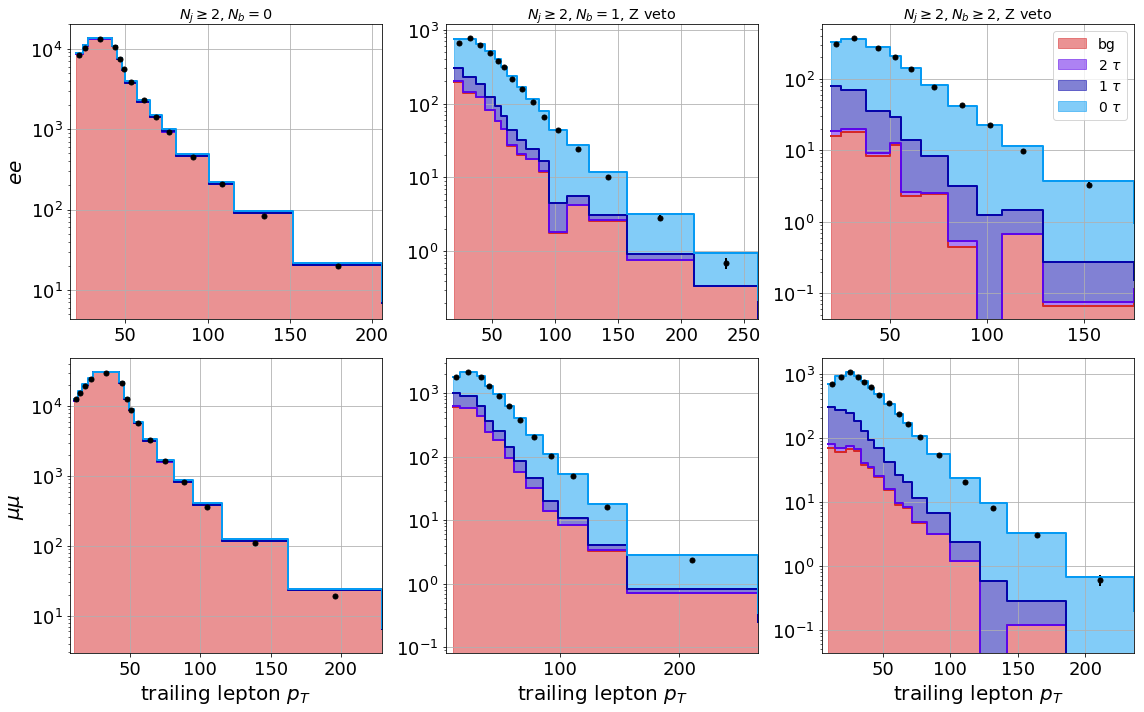

In [4]:
# visualize toy data (ee, mumu)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 3, figsize=(16, 10), facecolor='white')
for i, selection in enumerate(['ee', 'mumu']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel('trailing lepton $p_{T}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        #data = toy_data[selection][category]
        data = templates['data']['val']
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items())) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items())) 
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset == 'zjets_alt':
                temp = np.array([t['val'].values for _, t in template.items()])
                h_bg += temp.sum(axis=0)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ll.pdf')
plt.show()

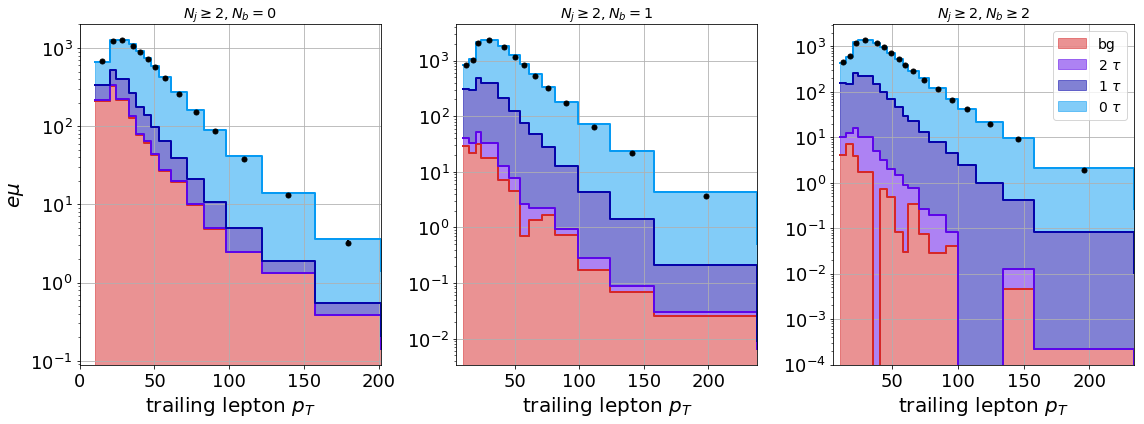

In [5]:
# visualize toy data (emu)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(1, 3, figsize=(16, 6), facecolor='white')

selection = 'emu'
for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
    ax = axes[j]
    ax.set_title(pt.categories[category].label)
    ax.set_xlabel('trailing lepton $p_{T}$')
            
    if j == 0:
        ax.set_ylabel(plot_labels[selection][1])

    # get and plot the data 
    templates = template_data['templates']
    bins = template_data['bins'][:-1]
    dx = (bins[1:] - bins[:-1])
    dx = np.append(dx, dx[-1]) 
    x  = bins + dx/2            

    #data = toy_data[selection][category]
    data = templates['data']['val']
    ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)

    h_bg      = np.zeros(data.shape)
    h_twotau  = np.zeros(data.shape)
    h_onetau  = np.zeros(data.shape)
    h_nominal = np.zeros(data.shape)
    for dataset, template in templates.items():
        if dataset in ['ttbar', 't']:
            signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items())) 
            h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
            h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
            h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
        elif dataset == 'wjets':
            signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items())) 
            h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
            h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
        elif dataset == 'zjets_alt':
            temp = np.array([t['val'].values for _, t in template.items()])
            h_bg += temp.sum(axis=0)
        elif dataset != 'data':
            h_bg += template['val']

    h_nominal += h_bg
    h_twotau += h_bg
    h_onetau += h_twotau

    ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')

    ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
    ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
    ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
    ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')

    xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
    ax.set_xlim(xmin, xmax)
    #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
    ax.set_yscale('log')
    ax.grid()

axes[-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_emu.pdf')
plt.show()

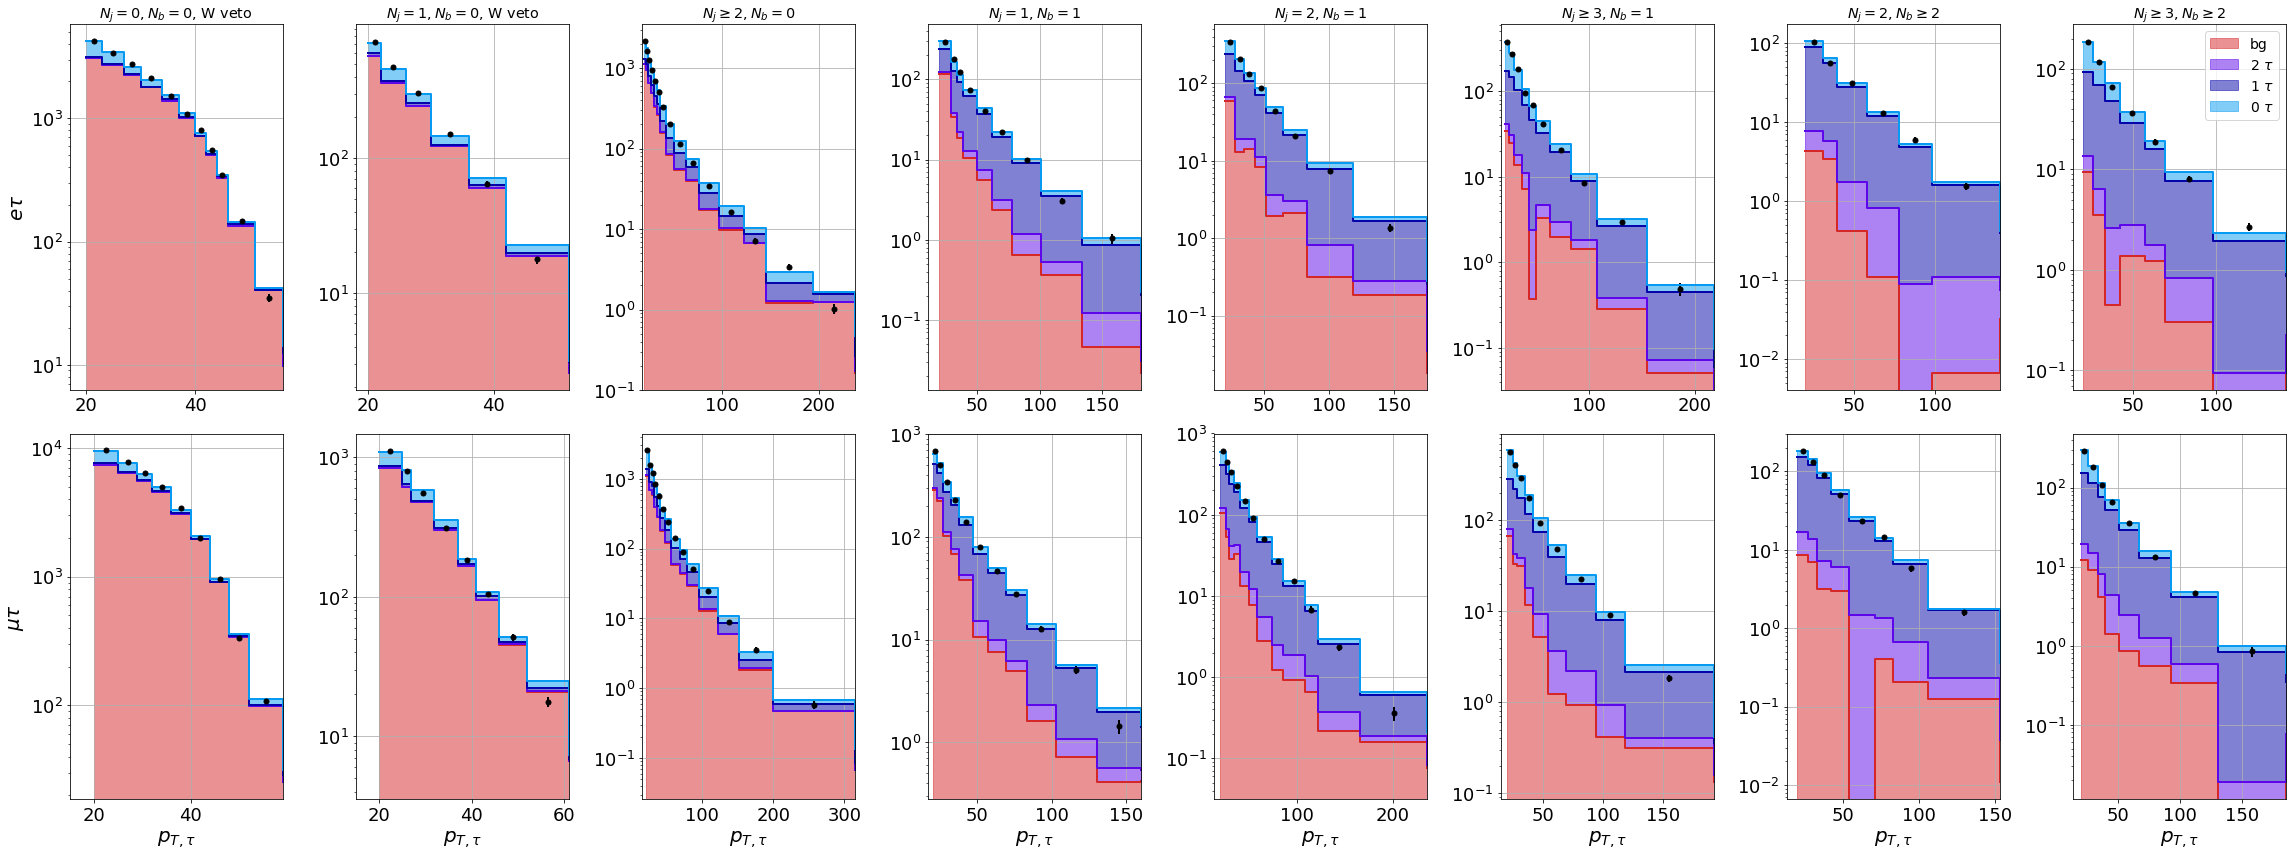

In [6]:
# visualize toy data (mutau, etau)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 8, figsize=(32, 12), facecolor='white')
for i, selection in enumerate(['etau', 'mutau']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        #print(selection, category)
        
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel(r'$p_{T, \tau}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        #data = toy_data[selection][category]
        data = templates['data']['val']
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items())) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'zjets_alt':
                temp = np.array([t['val'].values for _, t in template.items()])
                h_bg += temp.sum(axis=0)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items()))
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ltau.pdf')
plt.show()

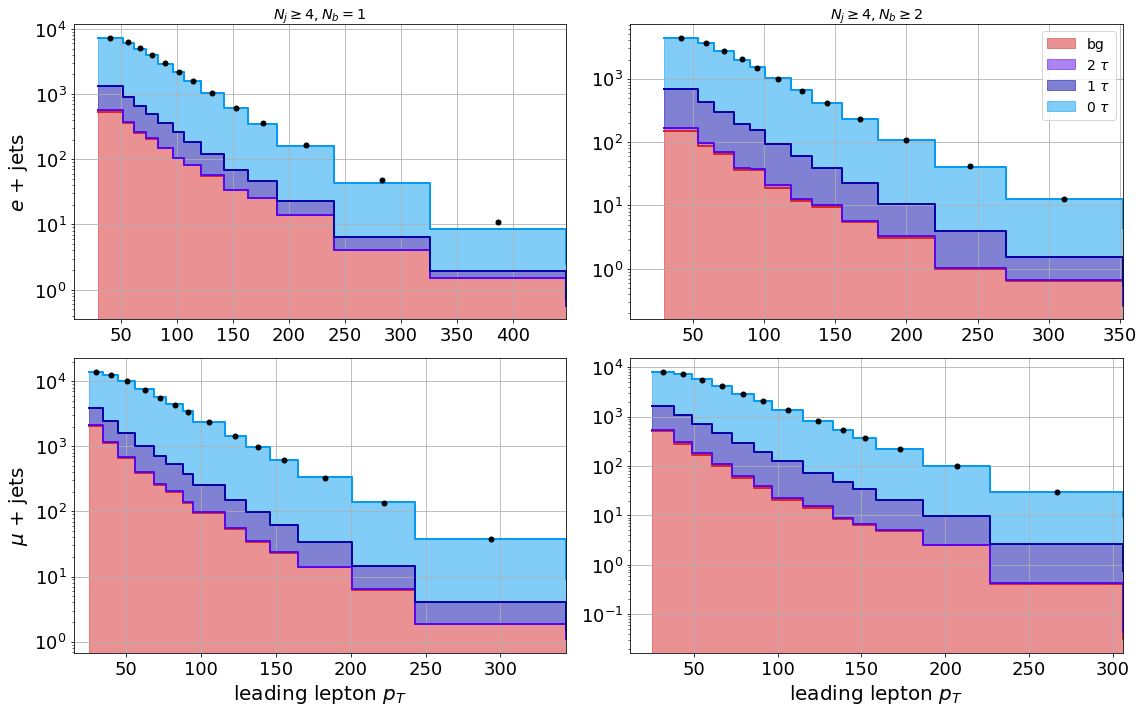

In [7]:
# visualize toy data (e+jet, mu+jet)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white')
for i, selection in enumerate(['e4j', 'mu4j']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel('leading lepton $p_{T}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        #data = toy_data[selection][category]
        data = templates['data']['val']
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items()))
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_dict(dict((dm, t['val']) for dm, t in template.items()))
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset == 'zjets_alt':
                temp = np.array([t['val'].values for _, t in template.items()])
                h_bg += temp.sum(axis=0)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ljets.pdf')
plt.show()

In [8]:
# initialize data for likelihood scans and calculation of the NLL covariance
params_init = fit_data.get_params_init()
cost_type = 'poisson'
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type, no_shape=False)

# calculate covariance matrix from the inverse of the Hessian of the NLL
stderr, corr = fh.calculate_covariance(fobj, params_init)

In [9]:
# plot errors
params = fit_data._parameters
p_labels = list(params.index.values)
params_init = params.val_init.values

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', len(p_labels))
pd.set_option('display.max_rows', len(p_labels))

pct_err = pd.DataFrame(np.array([100*params_init[:4], 100*stderr[:4], 100*stderr[:4]/params_init[:4]]).T, 
                       index=p_labels[:4], 
                       columns=['params_init', 'stderr', 'stderr (%)']
                      )
pct_err

,params_init,stderr,stderr (%)
beta_e,10.800,0.112,1.038
beta_mu,10.800,0.117,1.081
beta_tau,10.800,0.192,1.779
beta_h,67.600,0.286,0.423


In [10]:
# plot nuisance parameter errors and constraints
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pct_err = pd.DataFrame(np.array([params_init, 100*params.err_init, 100*stderr, params.err_init/stderr]).T, 
                       index=p_labels, 
                       columns=['params_init', 'stderr_pre (%)', 'stderr_post (%)', 'constraint']
                      )
pct_err[4:].to_csv('local_data/pulls.csv')

pct_err.index = [fit_data._parameters.loc[p].label if p in fit_data._parameters.index else p for p in pct_err.index]
pct_err[4:].to_latex('local_data/pulls.tex', escape=False)
pct_err[4:]

,params_init,stderr_pre (%),stderr_post (%),constraint
$b_{\tau_{e}}$,0.178,0.040,0.040,1.000
$b_{\tau_{\mu}}$,0.174,0.040,0.040,1.002
$b_{\tau_{h}}$,0.648,0.100,0.100,1.001
$L_{int}$,1.000,2.500,1.679,1.489
$\sigma_{VV}$,1.000,10.000,8.527,1.173
$\sigma_{t\bar{t}}$,1.000,5.000,2.093,2.388
$\sigma_{tW}$,1.000,10.000,7.015,1.426
$\sigma_{W}$,1.000,5.000,2.672,1.871
"QCD norm (e, iso)",1.000,25.000,8.817,2.835
"QCD norm ($\mu$, iso)",1.000,5.000,2.664,1.877


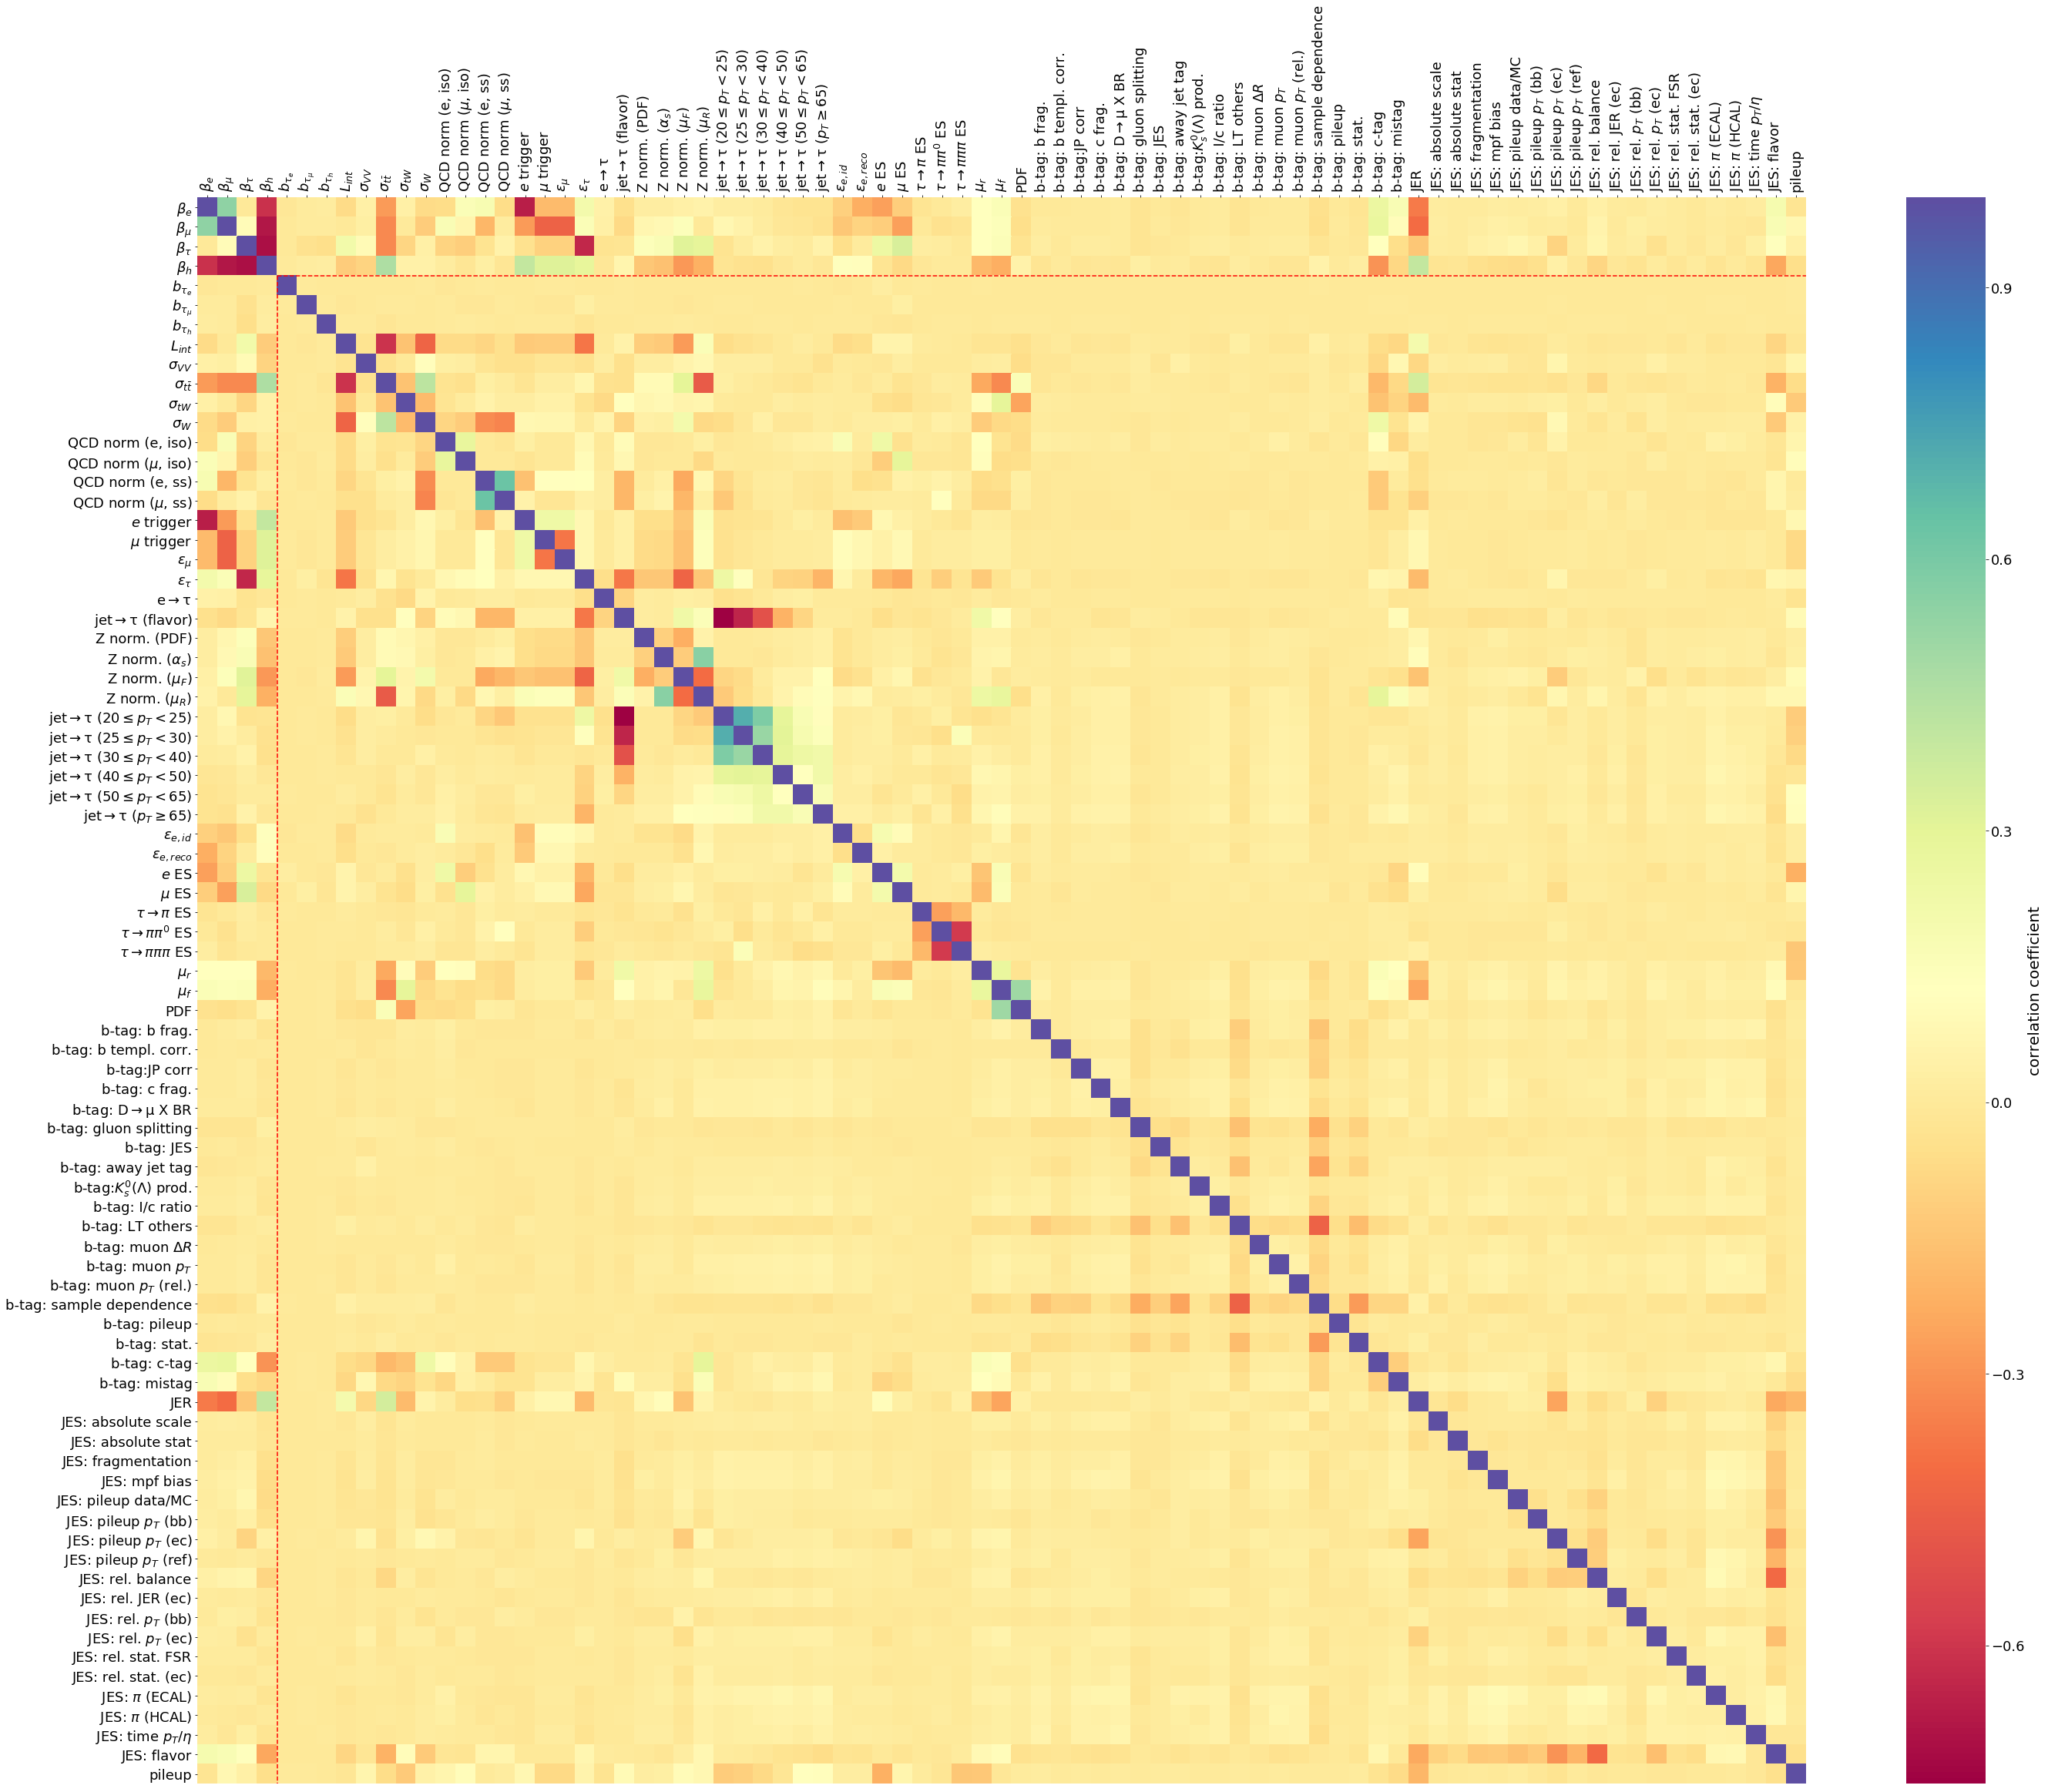

In [11]:
# produce correlation matrix
p_labels_fancy = fit_data._parameters.label
df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.to_latex('local_data/corr_table_full.tex')
df_corr.to_csv('local_data/corr_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(40, 32))
#fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(12, 8))
sns.heatmap(df_corr, cmap='Spectral', annot=False, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('plots/systematics/correlation_matrix.pdf')
plt.show()

### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [12]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange
from multiprocessing import Pool

def reduced_objective(p, mask, p_init):
    masked_p = p_init.copy()
    masked_p[mask] = p
    return fit_data.objective(masked_p, data=toy_data, cost_type=cost_type, no_shape=False)

# stat only
mask = np.ones(len(params_init)).astype(bool)
mask[4:] = False
fobj = partial(reduced_objective, mask=mask, p_init=params_init)
err_stat, _ = fh.calculate_covariance(fobj, params_init[:4])
err_stat = np.concatenate([err_stat, np.zeros(params_init[4:].size)])

# n-1 systematics
pool = Pool(processes=12)
results = []
for i in range(4, len(params_init)):
    mask = np.ones(len(params_init)).astype(bool)
    mask[i] = False
    fobj = partial(reduced_objective, mask=mask, p_init=params_init)
    res = pool.apply_async(fh.calculate_covariance, args=(fobj, np.delete(params_init, i)))
    results.append(res)
    
pool.close()
pool.join()

output = [r.get() for r in results]

In [13]:
# convert to errors
sub_errs = [o[0] for o in output]
errs = np.array([np.concatenate([sub_errs[i-4][:i], [0], sub_errs[i-4][i:]]) for i in range(4, params_init.size)])
errs = np.vstack([err_stat, errs, stderr])
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.multiply(100)

,beta_e,beta_mu,beta_tau,beta_h,br_tau_e,br_tau_mu,br_tau_h,lumi,xs_diboson,xs_ttbar,xs_t,xs_wjets,e_fakes,mu_fakes,e_fakes_ss,mu_fakes_ss,trigger_e,trigger_mu,eff_mu,eff_tau,misid_tau_e,misid_tau_h,pdf_zjets,alpha_s_zjets,mu_f_zjets,mu_r_zjets,misid_tau_0,misid_tau_1,misid_tau_2,misid_tau_3,misid_tau_4,misid_tau_5,eff_id_e,eff_reco_e,escale_e,escale_mu,escale_tau_0,escale_tau_1,escale_tau_10,mur,muf,pdf,btag_bfragmentation,btag_btempcorr,btag_cb,btag_cfragmentation,btag_dmux,btag_gluonsplitting,btag_jes,btag_jetaway,btag_ksl,btag_l2c,btag_ltothers,btag_mudr,btag_mupt,btag_ptrel,btag_sampledependence,btag_pileup,btag_statistic,ctag,mistag,jer,jes_abs_scale,jes_abs_stat,jes_fragmentation,jes_abs_mpf_bias,jes_pileup_data_mc,jes_pileup_pt_bb,jes_pileup_pt_ec1,jes_pileup_pt_ref,jes_relative_bal,jes_relative_jer_ec1,jes_relative_pt_bb,jes_relative_pt_ec1,jes_relative_stat_fsr,jes_relative_stat_ec,jes_single_pion_ecal,jes_single_pion_hcal,jes_time_pt_eta,jes_flavor_qcd,pileup
stat only,0.012,0.010,0.056,0.054,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
br_tau_e,0.112,0.117,0.192,0.286,0.000,0.040,0.100,1.679,8.527,2.093,7.015,2.672,8.817,2.664,2.522,3.467,0.849,0.840,0.840,1.881,29.033,3.135,95.970,94.159,52.368,25.467,47.863,56.356,58.424,75.317,79.242,84.069,76.672,98.499,38.460,64.350,42.846,25.393,30.627,42.702,45.849,84.641,101.369,99.043,100.454,101.912,100.861,98.510,98.493,98.983,100.549,99.509,91.624,100.560,102.560,100.076,84.022,97.983,95.500,73.197,97.663,61.105,98.321,96.329,96.719,95.602,91.699,97.625,95.199,92.011,90.646,98.980,96.093,95.807,100.106,97.934,96.705,95.688,101.364,73.987,33.722
br_tau_mu,0.112,0.117,0.192,0.286,0.040,0.000,0.100,1.679,8.527,2.093,7.015,2.672,8.817,2.664,2.522,3.467,0.849,0.840,0.840,1.880,29.033,3.135,95.969,94.158,52.366,25.466,47.863,56.356,58.424,75.317,79.242,84.069,76.674,98.499,38.471,64.323,42.846,25.393,30.627,42.702,45.849,84.641,101.369,99.043,100.454,101.912,100.861,98.510,98.493,98.983,100.549,99.509,91.624,100.560,102.560,100.076,84.022,97.983,95.500,73.197,97.662,61.105,98.321,96.329,96.719,95.602,91.699,97.625,95.198,92.011,90.646,98.980,96.093,95.807,100.106,97.934,96.705,95.688,101.364,73.987,33.722
br_tau_h,0.112,0.117,0.192,0.286,0.040,0.040,0.000,1.679,8.527,2.093,7.015,2.672,8.817,2.664,2.522,3.467,0.849,0.840,0.840,1.880,29.033,3.135,95.969,94.158,52.365,25.467,47.863,56.356,58.424,75.317,79.242,84.069,76.674,98.499,38.468,64.344,42.846,25.393,30.627,42.702,45.849,84.641,101.369,99.043,100.454,101.912,100.861,98.510,98.493,98.983,100.549,99.509,91.624,100.560,102.560,100.076,84.022,97.983,95.500,73.197,97.663,61.105,98.321,96.329,96.719,95.602,91.699,97.625,95.198,92.011,90.646,98.980,96.093,95.807,100.106,97.934,96.705,95.688,101.364,73.987,33.722
lumi,0.112,0.117,0.188,0.284,0.040,0.040,0.100,0.000,8.522,1.661,6.931,2.409,8.799,2.658,2.513,3.464,0.842,0.834,0.834,1.740,29.033,3.131,95.340,93.408,50.305,25.132,47.786,56.316,58.412,75.317,79.225,84.069,76.509,98.366,38.405,64.228,42.843,25.393,30.627,42.688,45.837,84.553,101.364,99.043,100.442,101.907,100.842,98.506,98.493,98.983,100.542,99.495,91.588,100.558,102.541,100.066,83.960,97.983,95.497,73.088,97.374,59.850,98.312,96.329,96.696,95.558,91.666,97.606,95.196,92.010,90.633,98.978,96.087,95.807,100.094,97.934,96.685,95.686,101.358,73.736,33.718
xs_diboson,0.112,0.117,0.191,0.285,0.040,0.040,0.100,1.678,0.000,2.092,7.015,2.655,8.812,2.664,2.521,3.463,0.848,0.840,0.840,1.879,29.026,3.132,95.941,94.135,52.271,25.381,47.847,56.335,58.408,75.317,79.242,84.015,76.674,98.500,38.469,64.335,42.846,25.393,30.627

In [14]:
# print table
beta_vars = errs.iloc[:,:4]**2

for i in trange(1, beta_vars.shape[0] - 1):
    dvar = beta_vars.iloc[-1] - beta_vars.iloc[i]
    beta_vars.iloc[i] = dvar 
    
beta_syst = beta_vars.iloc[-1] - beta_vars.iloc[0]
beta_syst.name = 'syst'
beta_errs = beta_vars.iloc[:-1]
beta_errs = beta_errs.append(beta_syst)
beta_errs = beta_errs.append(beta_vars.iloc[-1])
beta_errs = np.sqrt(beta_errs)

beta_errs.divide(params_init[:4]/100, axis=1).to_latex('local_data/errors.tex')
beta_errs.divide(params_init[:4]/100, axis=1).to_csv('local_data/errors.csv')
beta_errs.divide(params_init[:4]/100, axis=1)

100%|██████████| 77/77 [00:00<00:00, 3574.84it/s]


,beta_e,beta_mu,beta_tau,beta_h
stat only,0.114,0.095,0.517,0.079
br_tau_e,0.009,0.004,0.000,0.002
br_tau_mu,0.008,0.013,0.066,0.007
br_tau_h,0.016,0.010,0.087,0.010
lumi,0.065,0.001,0.385,0.051
xs_diboson,0.043,0.031,0.170,0.039
xs_ttbar,0.288,0.354,0.577,0.195
xs_t,0.040,0.004,0.155,0.018
xs_wjets,0.067,0.126,0.067,0.020
e_fakes,0.060,0.182,0.166,0.007


In [15]:
jes_mask = np.array([True if ('jes' in pname and 'btag' not in pname) else False for pname in beta_errs.index])
btag_mask = np.array([True if 'btag' in pname else False for pname in beta_errs.index])
tau_misid_mask = np.array([True if ('misid_tau' in pname and pname not in ['misid_tau_e', 'misid_tau_h']) else False for pname in beta_errs.index])

btag_errs = beta_errs[btag_mask]
jes_errs = beta_errs[jes_mask]
tau_misid_errs = beta_errs[tau_misid_mask]

summary_errs = beta_errs[~btag_mask&~jes_mask&~tau_misid_mask].copy()
summary_errs.index = [fit_data._parameters.loc[p].label if p in fit_data._parameters.index else p for p in summary_errs.index]
summary_errs.loc['b-tag',:] = np.sqrt(np.sum(btag_errs**2))
summary_errs.loc['JES',:]  = np.sqrt(np.sum(jes_errs**2))
summary_errs.loc[r'$\sf jet\rightarrow\tau$',:]  = np.sqrt(np.sum(tau_misid_errs**2))

summary_errs = summary_errs.divide(params_init[:4]/100, axis=1)
summary_errs.to_latex('local_data/summary_errors.tex', escape=False)
summary_errs.to_csv('local_data/summary_errors.csv')
summary_errs

,beta_e,beta_mu,beta_tau,beta_h
stat only,0.114,0.095,0.517,0.079
$b_{\tau_{e}}$,0.009,0.004,0.000,0.002
$b_{\tau_{\mu}}$,0.008,0.013,0.066,0.007
$b_{\tau_{h}}$,0.016,0.010,0.087,0.010
$L_{int}$,0.065,0.001,0.385,0.051
$\sigma_{VV}$,0.043,0.031,0.170,0.039
$\sigma_{t\bar{t}}$,0.288,0.354,0.577,0.195
$\sigma_{tW}$,0.040,0.004,0.155,0.018
$\sigma_{W}$,0.067,0.126,0.067,0.020
"QCD norm (e, iso)",0.060,0.182,0.166,0.007
